# Plotting mean speed over time for a movie.

## The mean over all objects, at one time-point.

In this notebook we will show how to measure and plot the mean cell speed over time from TrackMate data.
This image comes from a cell migration movie, acquired in the lab of Guillaume JACQUEMET, in the University of Turky, Finland. 
It belongs to the demo dataset of the last TrackMate paper (https://www.nature.com/articles/s41592-022-01507-1).

![The image the data come from](images/TrackMate-image_01.png)

TrackMate can gives you averages of quantities over a track. 
For instance, you can get the mean speed for one cell, averaged over all the time-points the cell is imaged in. 
But what about getting the mean over all cells at one time-point, then plotting this mean for all time-points?
This would be relevant for instance if you want to see how the dynamics of a cell population change over time.

TrackMate does not offer facilities to do that, so we need to do it elsewhere, _e.g._ in Python, with data exported from TrackMate.

## Exporting the data to CSV.

Here we want to plot the speed averaged for all cells. 
So we need the instantaneous speed.
Because the instantaneous speed is defined only in between two spots, this feature belongs to links, or edges, in TrackMate. 
So we need to export the `edges` table in TrackMate:

![Where to export the data from in TrackMate](images/TrackMate-image_02.png)

Save the CSV somewhere, and then you can use the script below to analyse it.
In this course, we will use the one stored in `data/TrackMate-edgeTable.csv`.

## What we will do and learn.

This tutorial will mainly be learning some 'advanced' features of Pandas, that are similar to the pivot table we find in Excel.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

path = 'data/TrackMate-edgeTable.csv'

# Load the table.
df = pd.read_csv(path)

# Display its head.
print(df.head())


               LABEL  TRACK_ID  SPOT_SOURCE_ID  SPOT_TARGET_ID  \
0              Label  Track ID  Source spot ID  Target spot ID   
1              Label  Track ID       Source ID       Target ID   
2                NaN       NaN             NaN             NaN   
3  ID21672 → ID22000         0           21672           22000   
4  ID11941 → ID12177         0           11941           12177   

            LINK_COST  DIRECTIONAL_CHANGE_RATE               SPEED  \
0           Edge cost  Directional change rate               Speed   
1                Cost                   γ rate               Speed   
2              (cost)                (rad/min)         (pixel/min)   
3  7.2609458070697315        1.458552901814804   2.694614222308962   
4  10.216988304241653       0.3960839492293604  3.1964024002371247   

         DISPLACEMENT  EDGE_TIME    EDGE_X_LOCATION    EDGE_Y_LOCATION  \
0        Displacement  Edge time             Edge X             Edge Y   
1               Disp.     Edge T  

We have some data massaging to do.

We see that the CSV files contains 4 lines of header!
One for the feature key (e.g. `SPEED`), one for the name (`Speed`), one for the short name (the same) and one for the units (here: `pixel/min`).

The first row of CSV file has been used as column labels, but the 2nd to 4th have been added as strings to the table data.
As a consequence, all the columns are considered to be made of strings. 
Let's fix this.

First, let's remove the first 3 rows, that correspond to names and units.


In [9]:
# Remove the first 3 lines (names and units).
df = df.drop( [0,1,2])

Then let's remove the `LABEL` column, that has string content.

In [10]:
# Remove the label column, it is not numeric.
df = df.drop(labels='LABEL', axis=1)

Finally, let's convert all the table data to numeric.

In [11]:
# Convert everything to numbers, because some columns 
# were imported as text.
df = df.apply(pd.to_numeric)

print(df.head())

   TRACK_ID  SPOT_SOURCE_ID  SPOT_TARGET_ID  LINK_COST  \
3         0           21672           22000   7.260946   
4         0           11941           12177  10.216988   
5         0           19800           20051   5.033443   
6         0           21668           21886   1.663966   
7         0            3440            3677  16.510380   

   DIRECTIONAL_CHANGE_RATE     SPEED  DISPLACEMENT  EDGE_TIME  \
3                 1.458553  2.694614      2.694614       75.5   
4                 0.396084  3.196402      3.196402       39.5   
5                 0.454160  2.243534      2.243534       68.5   
6                 2.959189  1.289948      1.289948       75.5   
7                 1.063614  4.063297      4.063297        6.5   

   EDGE_X_LOCATION  EDGE_Y_LOCATION  EDGE_Z_LOCATION  MANUAL_EDGE_COLOR  
3       912.148800       283.871535              0.0                NaN  
4       914.365026       323.184449              0.0                NaN  
5       945.527254       285.977912   

Et voilà !
Now we can analyze the data in our table. 

So we want to compute the mean of the `SPEED` values, but averaged over all the cells in a given time-point.
The time-point is indexed in the table by the feature `EDGE_TIME`. 
So we want to group all values based on `EDGE_TIME`, and take the mean over all the `SPEED` values for rows that have a common `EDGE_TIME` value.

In Pandas this is done using the `groupby` method:

In [12]:

# Make a new table where we group everything by 'EDGE_TIME',
# and within a group, compute the mean of 'SPEED'
speed = df.groupby('EDGE_TIME')[['SPEED']].mean()
# The new table uses 'EDGE_TIME' as an index (or 'x axis'), very convenient.

print(speed)


              SPEED
EDGE_TIME          
0.5        2.416612
1.5        2.423123
2.5        2.323619
3.0        2.593361
3.5        2.326947
...             ...
81.5       2.047730
82.0       3.545102
82.5       2.043039
83.5       2.316716
84.5       2.314667

[111 rows x 1 columns]


We now have what we need: a table made of a single column `SPEED` with `EDGE_TIME` as index. 
We can now plot it.

<AxesSubplot:xlabel='EDGE_TIME'>

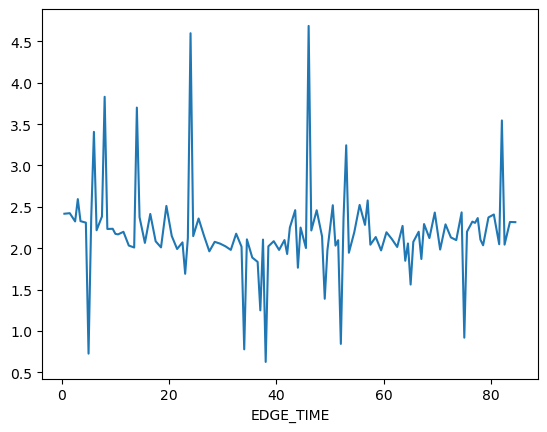

In [13]:

# Plot it. (I read the units from the image. Pixels are not calibrated but 
# we know the frame interval.)

speed['SPEED'].plot(x='time (min)', y='cell speed (pixel/min')

We see that there are some bumps in the speed. 
Because we average over so many cells, it is improbably that it is coming from a synchronized cell movement. 
Most likely, it is caused by door slamming. 
We can fiter them out using a rolling median. We need a window of 5 time-points to filter the bumps out.

Pandas, which is a wonderful library, has a function to apply a rolling median, cleverly called `rolling`.
With the following command, we add a new column (`FILTERED_SPEED`) with the filtered speed value.

<AxesSubplot:xlabel='EDGE_TIME'>

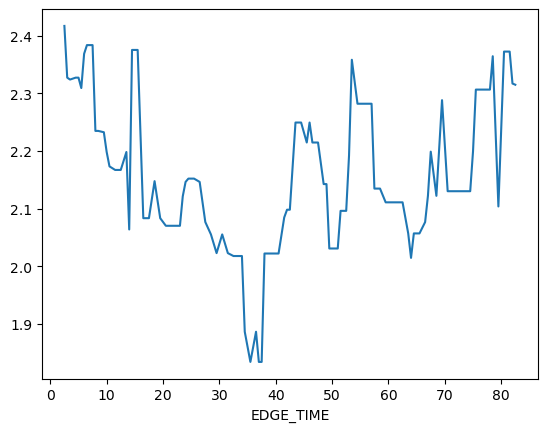

In [14]:
speed['FILTERED_SPEED'] = speed['SPEED'].rolling(5, center=True).median()

# Then we plot it.
speed['FILTERED_SPEED'].plot(x='time (min)', y='cell speed (pixel/min')

Ok now we see clearer. 
It seems that the speed has a trend: early in the movie that cells start moviing quicky, but there is a small decrease in speed before it reaches a plateau. 
Let's quantify that.

In [16]:

# Early movie speed.
early = speed.index < 10 # first 10 minutes

# early speed:
es = speed[early]['FILTERED_SPEED']
print('First 10 minutes: speed = %.2f ± %.2f pixels/min' % (es.mean(), es.std()))

# Later in the movie 
late = (speed.index > 20) & (speed.index < 30)

# late speed:
ls = speed[late]['FILTERED_SPEED']
print('Late, between 20 and 30 minutes: speed = %.2f ± %.2f pixels/min' % (ls.mean(), ls.std()))

First 10 minutes: speed = 2.32 ± 0.06 pixels/min
Late, between 20 and 30 minutes: speed = 2.10 ± 0.04 pixels/min


So there is indeed a difference in speed early and late in the movie when it comes to cell speed.
This difference is small, but we could detect it reliably. 

The next questions are:
1. Is it significant? This is left to the reader as an exercise.
2. What causes this decrease, if significant? It could be phototoxicity. 
Strong illumination in fluorescence microscopy has been shown to slow down cell.
But it could also be a biological effect linked to migration or having more space. 
Making sense of this observation takes much more efforts on the biology side.
But these scripts cover the analysis in a convenient and fast way.